In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Modeling

In [2]:
class FC_Block(nn.Module) : 
    def __init__(self, input_dim, output_dim) : 
        super(FC_Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU(inplace = True)
        self.bn = nn.BatchNorm1d(output_dim)
        self.dr = nn.Dropout(.1)

    def forward(self, x) : 
        out = self.linear(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dr(out)
        return out

In [64]:
class VAE(nn.Module) : 

  def __init__(self, block) : 
    super(VAE,self).__init__()
    self.encoder = nn.Sequential(
        block(28*28, 256),
        block(256,64),
    )
    self.fc_mu = nn.Linear(64,10)
    self.fc_sigma = nn.Linear(64,10)
    self.decoder = nn.Sequential(
        block(10,64),
        block(64,256),
        nn.Linear(256,28*28),
        nn.Sigmoid()
    )

  def reparam(self, mu, sigma) : 
    eps = torch.randn_like(sigma)
    return mu + eps * torch.exp(0.5 * sigma)

  def encode(self, x) : 
    hid = self.encoder(x)
    mu = self.fc_mu(hid)
    sigma = self.fc_sigma(hid)
    z = self.reparam(mu,sigma)
    return mu, sigma, z  

  def decode(self, z) : 
    recon = self.decoder(z)
    return recon

  def forward(self, x) : 
    batch_size = x.size(0)
    mu, sigma, z = self.encode(x.view(batch_size,28*28))
    out = self.decode(z)
    return out, mu, sigma, z


In [65]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
vae = VAE(FC_Block).to(device)

In [66]:
BCE = nn.BCELoss(reduction='sum')

def loss_fn(x, recon, mu, sigma) : 
  BCE_loss = BCE(recon, x.view(-1,28*28))
  KLD_loss = -0.5 * torch.sum(1 + sigma -mu.pow(2) - sigma.exp())
  return BCE_loss + KLD_loss

optimizer = optim.Adam(vae.parameters(), lr = 0.05)

# Load Data

In [67]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [48000, 12000])

In [68]:
dataloaders = {}
batch_size = 480
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Training

In [69]:
def saveModel(model, path): 
    torch.save(model.state_dict(), path) 

In [70]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_val_loss = 100000000
    early_stop = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, mu, log_var, z = model(inputs)
                    loss = criterion(inputs, outputs, mu, log_var)  # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                saveModel(model, 'VAE.pth')
                early_stop = 0
            elif phase == 'val' : 
                early_stop += 1
            
            if early_stop >= 5  :
                break;

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))


    # load best model weights
    model.load_state_dict(torch.load('VAE.pth'))
    return model, train_loss_history, val_loss_history

In [71]:
best_model, train_history, valid_history = train_model(vae, dataloaders, loss_fn, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 198.2431
val Loss: 153.7613

Epoch 1/9
----------
train Loss: 149.3380
val Loss: 136.5973

Epoch 2/9
----------
train Loss: 141.4644
val Loss: 131.4034

Epoch 3/9
----------
train Loss: 138.0139
val Loss: 128.1033

Epoch 4/9
----------
train Loss: 135.9988
val Loss: 125.6921

Epoch 5/9
----------
train Loss: 134.0198
val Loss: 123.8980

Epoch 6/9
----------
train Loss: 132.9241
val Loss: 124.1048

Epoch 7/9
----------
train Loss: 132.4987
val Loss: 122.3712

Epoch 8/9
----------
train Loss: 131.8288
val Loss: 123.5678

Epoch 9/9
----------
train Loss: 131.3733
val Loss: 123.4258

Training complete in 1m 20s
Best val Loss: 122.371246


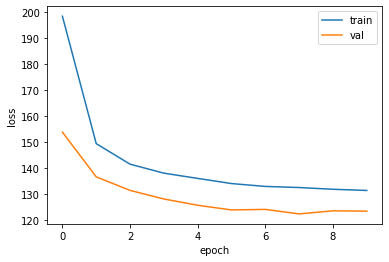

In [74]:
import matplotlib.pyplot as plt

# Let's draw a learning curve like below.
plt.plot(train_history, label='train')
plt.plot(valid_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [77]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, mu, log_var,z  = best_model(inputs)
        test_loss = loss_fn(inputs, outputs, mu, log_var)
        
        running_loss += test_loss.item()

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)   

121.625298828125


torch.Size([400, 784])


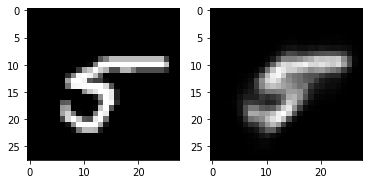

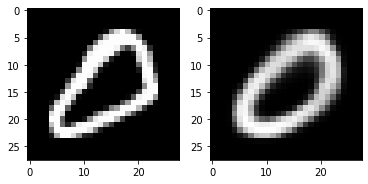

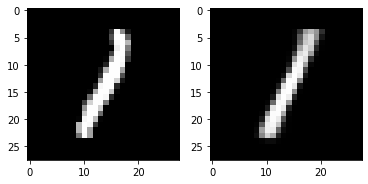

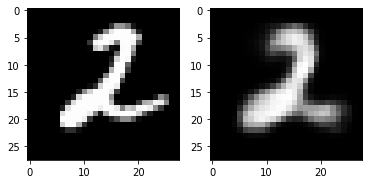

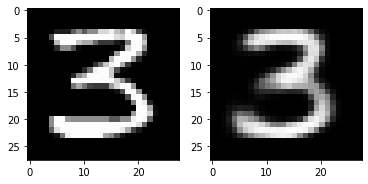

In [78]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()